In [1]:
from faker import Faker
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random 
from collections import Counter

from functions import *

In [2]:
fake = Faker()

In [3]:
nrow = 300000

In [4]:
df = pd.DataFrame()

In [5]:
# create an id and pol_ref field
df['id'] = range(1, nrow+1)
df['pol_ref']= 'pol'+ str(random.randint(0,99)).zfill(5) + df['id'].astype(str)

In [6]:
# add customer information
df['name'] = [fake.name()
              for _ in range(nrow)]
df['address'] = [fake.address()
              for _ in range(nrow)]

In [7]:
# this column is purposely non-sensical
gender=['M', 'F']

gender_prob=[0.5, 0.5]

df['gender'] = np.random.choice(gender, nrow, p=gender_prob)

In [8]:
cars=['Abarth','Aixam','AlfaRomeo','Audi','Austin','Bentley','BMW','Buick','Cadillac','Chevrolet','Chrysler',\
      'Citroen','Dacia','Daewoo','Daihatsu','Daimler','Dodge','DSAUTOMOBILES','Fiat','Ford','GMC','GreatWall',\
      'Honda','Hyundai','Infiniti','Isuzu','Iveco','Jaguar','JBA','Jeep','Kia','Lancia','LandRover','Lexus',\
      'Lincoln','LondonTaxisInternational','Telsa','Maserati','Mazda','Mercedes-Benz','MEV','MG','Microcar',\
      'MINI','Mitsubishi','Morris','Nissan','Oldsmobile','Opel','Panther','Perodua','Peugeot','Pontiac','Porsche',\
      'Proton','Reliant','Renault','Rolls-Royce','Rover','Saab','SEAT','SKODA','Smart','Ssangyong','Subaru',\
      'Suzuki','Talbot','Tiger','Toyota','Triumph','TVR','Vauxhall','Volkswagen','Volvo','Westfield', 'AstonMartin']

cars_prob=[0.002,0.000,0.004,0.046,0.000,0.000,0.052,0.000,0.000,0.002,0.001,0.040,0.006,0.000,0.000,0.000,0.000,\
           0.005,0.037,0.133,0.000,0.000,0.024,0.032,0.001,0.000,0.000,0.008,0.000,0.002,0.030,0.000,0.006,0.003,\
           0.000,0.000,0.000,0.000,0.014,0.035,0.000,0.002,0.000,0.032,0.005,0.000,0.053,0.000,0.000,0.000,0.000,\
           0.051,0.000,0.001,0.000,0.000,0.041,0.000,0.000,0.002,0.023,0.026,0.006,0.001,0.001,0.015,0.000,0.000,\
           0.051,0.000,0.000,0.117,0.076,0.013,0.000,0.001]

df['car_make'] = np.random.choice(cars, nrow, p=cars_prob)

In [9]:
sports_premium_cars=['Porsche','Bentley', 'AstonMartin', 'Maserati','Rolls-Royce']
premium_cars=['AlfaRomeo','Audi', 'Infiniti', 'Lancia','Tesla','BMW', 'Jaguar', 'LandRover','Lexus','Mercedes-Benz']
everyday_cars=['Abarth','Renault','Smart','Saab','SEAT','SKODA','Citroen','DSAUTOMOBILES', 'Fiat','Ford', 'Jeep', 'Volvo', 'Volkswagen', 'Toyota', 'Mazda', 'MINI', 'Mitsubishi']
cheap_cars=['Ssangyong','Subaru''Rover','Peugeot','Nissan','Dacia','Daewoo','Daihatsu','GreatWall', 'Honda','Hyundai','Kia', 'Vauxhall', 'Suzuki']
collector_cars=['Aixam', 'Austin', 'Daimler','JBA', 'TVR', 'Triumph', 'Lincoln','LondonTaxisInternational']
imported_cars=['Proton','Reliant','Pontiac','Oldsmobile','Opel','Panther','Perodua','Morris','Buick','Cadillac','Chevrolet','Chrysler', 'Dodge', 'GMC', 'Isuzu','Iveco', 'Westfield', 'Talbot','Tiger','MEV','MG','Microcar']

def f(row):
    if row['car_make'] in(sports_premium_cars):
        val = random.randint(75000, 100000)
    
    elif row['car_make'] in(premium_cars):
        val = random.randint(35000, 80000)

    elif row['car_make'] in(everyday_cars):
        val = random.randint(25000, 55000)

    elif row['car_make'] in(cheap_cars):
        val = random.randint(17500, 30000)

    elif row['car_make'] in(collector_cars):
        val = random.randint(25000, 50000)

    elif row['car_make'] in(imported_cars):
        val = random.randint(30000, 60000)
        
    else:
        val=random.randint(17000, 100000)

    return val

df['car_value_as_new'] = df.apply(f, axis=1)
df['car_value_as_new'] = round(df['car_value_as_new']/1000)*1000

In [10]:
df['car_year'] = np.random.randint(1998, 2021, nrow)

In [11]:
def g(row):
    if row['car_make'] in(sports_premium_cars):
        val = random.randint(35, 72)
    
    elif row['car_make'] in(premium_cars):
        val = random.randint(28, 82)

    elif row['car_make'] in(everyday_cars):
        val = random.randint(17, 90)

    elif row['car_make'] in(cheap_cars):
        val = random.randint(17, 90)

    elif row['car_make'] in(collector_cars):
        val = random.randint(40, 90)

    elif row['car_make'] in(imported_cars):
        val = random.randint(46, 72)
        
    else:
        val=random.randint(17, 88)

    return val

df['pol_holder_age'] = df.apply(g, axis=1)

In [12]:
# this column is purposely non-sensical
contract=['Freelancer', 'Homeworking', 'Unemployed', 'Self-Employed', 'Contractor', 'Permanent Employee']

contract_prob=[0.01, 0.05, 0.05, 0.19, 0.1, 0.6]

df['pol_employment_type'] = np.random.choice(contract, nrow, p=contract_prob)

In [13]:
industry = ['Agriculture, Forestry, Fishing','Mining','Construction','Manufacturing','Transportation & Public Utilities',\
'Wholesale Trade','Retail Trade','Finance, Insurance, Real Estate','Services','Public Administration']

industry_prob=[0.01, 0.04, 0.15, 0.05, 0.05, 0.1, 0.15, 0.15, 0.15, 0.15]

df['pol_employment_industry'] = np.random.choice(industry, nrow, p=industry_prob)

In [14]:
def i(row):
    if row['car_make'] in(sports_premium_cars):
        val = random.randint(10, 25)
    
    elif row['car_make'] in(premium_cars):
        val = random.randint(3, 25)

    elif row['car_make'] in(everyday_cars):
        val = random.randint(1, 25)

    elif row['car_make'] in(cheap_cars):
        val = random.randint(1, 25)

    elif row['car_make'] in(collector_cars):
        val = random.randint(10, 25)

    elif row['car_make'] in(imported_cars):
        val = random.randint(10, 25)
        
    else:
        val=random.randint(1, 25)

    return val

df['pol_holder_licence_length'] = df.apply(i, axis=1)

In [15]:
def h(row):
    if row['car_make'] in(sports_premium_cars):
        val = random.randint(175, 205) #np.random.choice([175, 195, 205], nrow, p=[0.6, 0.2, 0.2])
    
    elif row['car_make'] in(premium_cars):
        val = random.randint(145, 175) #np.random.choice([145, 155, 165, 175], nrow, p=[0.25,0.25,0.25,0.25])

    elif row['car_make'] in(everyday_cars):
        val = random.randint(125, 155) #np.random.choice([125,135,145,155], nrow, p=[0.25,0.25,0.3,0.2])

    elif row['car_make'] in(cheap_cars):
        val = random.randint(125, 132) #np.random.choice([125,135], nrow, p=[0.5,0.5])

    elif row['car_make'] in(collector_cars):
        val = random.randint(95, 125) #np.random.choice([105,115,125,95], nrow, p=[0.3,0.3,0.3,0.1])

    elif row['car_make'] in(imported_cars):
        val = random.randint(95, 105) #np.random.choice([95,105], nrow, p=[0.25,0.75])
        
    else:
        val=random.randint(95, 155)

    return val

df['car_top_speed'] = df.apply(h, axis=1)
df['car_top_speed'] = round(df['car_top_speed']/10)*10

In [16]:
df['postcode_rating'] = np.random.randint(1, 50, nrow)
df['credit_rating'] = np.random.randint(1, 50, nrow)

In [17]:
df['other_named_driver'] = np.random.choice(['Yes', 'No'], nrow, p=[0.25,0.75])
df['criminal_convictions'] = np.random.choice(['2', '1', '0'], nrow, p=[0.001,0.002,0.997])

In [18]:
df['car_modified_indicator'] = np.random.choice(['No', 'Yes'], nrow, p=[0.999, 0.001])
df['car_colour'] = np.random.choice(['black', 'red', 'silver', 'purple', 'blue', 'white', 'grey', 'yellow', 'green', 'orange'], 
                                    nrow, p=[0.15, 0.1, 0.1, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [19]:
# day of collision
min_date = pd.to_datetime('2020-01-01')
max_date = pd.to_datetime('2020-12-31')
d = (max_date - min_date).days + 1
df['collision_date'] = (min_date + pd.to_timedelta(pd.np.random.randint(d,size=nrow), unit='d'))#.strftime('%m/%d/%Y')

df['collision_day'] = df['collision_date'].dt.day_name()
df['collision_month'] = df['collision_date'].dt.month_name()

In [20]:
df['exposure'] = 1

# Target Creation

In [21]:
cat1_dict={'Abarth':0,
'Aixam':0,
'AlfaRomeo':0,
'Audi':1,
'Austin':0,
'Bentley':0,
'BMW':1,
'Buick':0,
'Cadillac':0,
'Chevrolet':0,
'Chrysler':0,
'Citroen':0,
'Dacia':0,
'Daewoo':0,
'Daihatsu':0,
'Daimler':0,
'Dodge':0,
'DSAUTOMOBILES':0,
'Fiat':0,
'Ford':1,
'GMC':0,
'GreatWall':0,
'Honda':0,
'Hyundai':0,
'Infiniti':0,
'Isuzu':0,
'Iveco':0,
'Jaguar':0,
'JBA':0,
'Jeep':0,
'Kia':-1,
'Lancia':0,
'LandRover':1,
'Lexus':0,
'Lincoln':0,
'LondonTaxisInternational':0,
'Tesla':0,
'Maserati':0,
'Mazda':0,
'Mercedes-Benz':1,
'MEV':0,
'MG':0,
'Microcar':0,
'MINI':0,
'Mitsubishi':1,
'Morris':0,
'Nissan':0,
'Oldsmobile':0,
'Opel':0,
'Panther':0,
'Perodua':0,
'Peugeot':1,
'Pontiac':0,
'Porsche':0,
'Proton':0,
'Reliant':1,
'Renault':1,
'Rolls-Royce':0,
'Rover':0,
'Saab':0,
'SEAT':0,
'SKODA':0,
'Smart':0,
'Ssangyong':0,
'Subaru':1,
'Suzuki':0,
'Talbot':0,
'Tiger':0,
'Toyota':0,
'Triumph':0,
'TVR':0,
'Vauxhall':1,
'Volkswagen':0,
'Volvo':-1,
'Westfield':0,
'AstonMartin':0}

def cat1_transform(key):
    return cat1_dict[key]

cat1_tf=df['car_make'].apply(cat1_transform)

In [22]:
cat1_dict={'Freelancer':0, 
           'Homeworking':0, 
           'Unemployed':0, 
           'Self-Employed':-1, 
           'Contractor':-1, 
           'Permanent Employee':0}

cat2_tf=df['pol_employment_type'].apply(cat1_transform)

In [23]:
cat1_dict={'M':-0.1, 
           'F':0}

cat3_tf=df['gender'].apply(cat1_transform)

In [24]:
cat1_dict= {'Agriculture, Forestry, Fishing':0,
'Mining':0,
'Construction':-1,
'Manufacturing':0,
'Transportation & Public Utilities':-1,
'Wholesale Trade':0,
'Retail Trade':0,
'Finance, Insurance, Real Estate':-1,
'Services':0,
'Public Administration':1
}

cat4_tf=df['pol_employment_industry'].apply(cat1_transform)

In [25]:
cat1_dict={'Monday':0,
'Tuesday':0,
'Wednesday':0,
'Thursday':0,
'Friday':-1,
'Saturday':-1,
'Sunday':-0.5}

cat5_tf=df['collision_day'].apply(cat1_transform)

In [26]:
cat1_dict={'January':-1,
'February':-1,
'March':1,
'April':0,
'May':0,
'June':0,
'July':0,
'August':-1,
'September':0,
'October':0,
'November':-1,
'December':-1}

cat6_tf=df['collision_month'].apply(cat1_transform)

In [27]:
cat1_dict={'Yes':1,
'No':0}

cat7_tf=df['other_named_driver'].apply(cat1_transform)

In [28]:
def scaler(df, col):
    
    mean=df[col].mean()
    std=df[col].std()
    df[col + '_scl']=(df[col]-mean)/std

In [29]:
scaler(df, 'pol_holder_age')
scaler(df, 'car_value_as_new')
scaler(df, 'car_year')
scaler(df, 'postcode_rating')
scaler(df, 'credit_rating')
scaler(df,'car_top_speed')
scaler(df, 'pol_holder_licence_length')

In [30]:
target_name='large_collision'

In [31]:
mu, sigma = 0, 15
s = np.random.normal(mu, sigma, nrow)

# random noise
df[target_name] = s

df[target_name] = df[target_name] + (df['pol_holder_age_scl']**2)*-1 + \
(df['postcode_rating_scl'])*-1 + \
(df['credit_rating_scl']**5)*-1 + \
(df['car_top_speed_scl'])*-1 + \
(df['pol_holder_licence_length_scl']**3) + \
cat1_tf + cat2_tf + cat3_tf + cat4_tf + cat5_tf + cat6_tf +\
(df['car_value_as_new_scl']*df['pol_holder_age_scl']) + \
(df['car_top_speed_scl']*df['pol_holder_age_scl']) + \
cat5_tf * cat6_tf + \
cat7_tf * df['pol_holder_age_scl'] + \
df['car_year_scl']*df['car_top_speed_scl'] + \
(df['car_year_scl']*df['pol_holder_age_scl']) # age x car year interaction

In [32]:
df[target_name] = np.where(df[target_name] <= np.percentile(df[target_name], 20), 1, 0)

In [33]:
cols=['car_year', 
'car_make',
'car_value_as_new',
'pol_holder_age',
'postcode_rating',
'credit_rating',
'other_named_driver',
'criminal_convictions',
'car_modified_indicator',
'car_top_speed', 
'car_colour',
'pol_holder_licence_length',
'gender',
'pol_employment_type',
'pol_employment_industry',
'collision_day',
'collision_month']

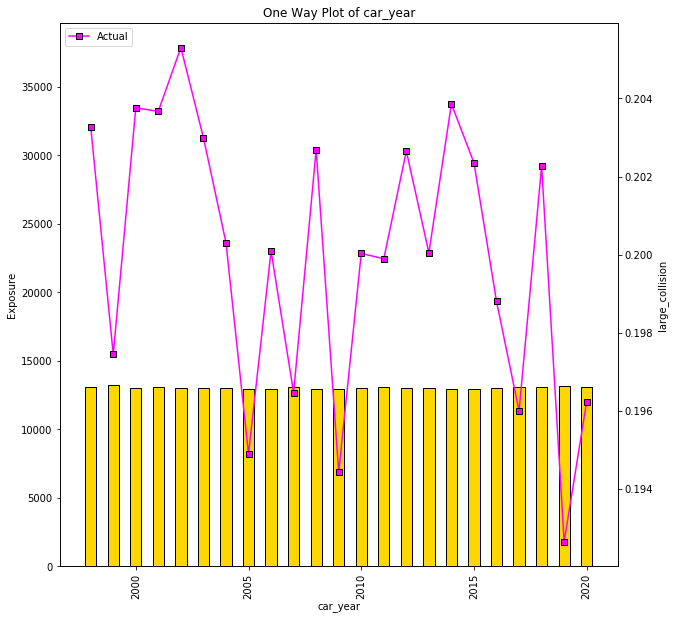

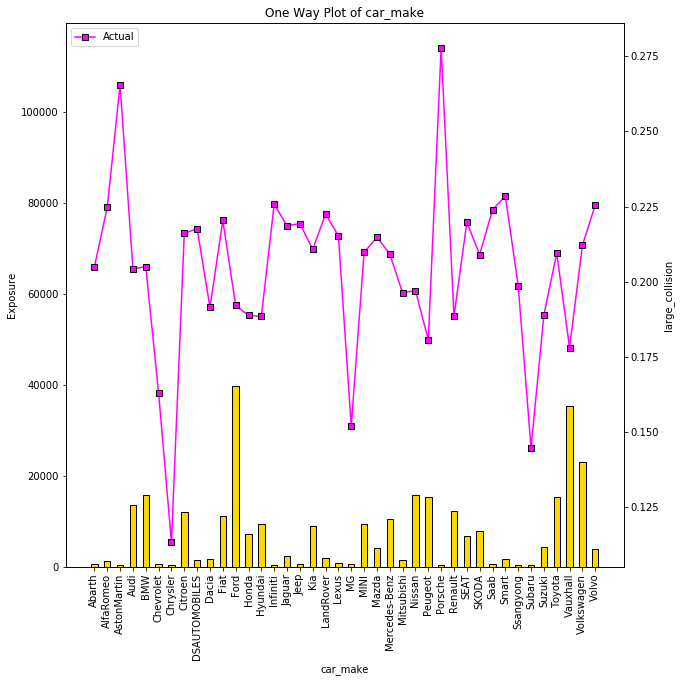

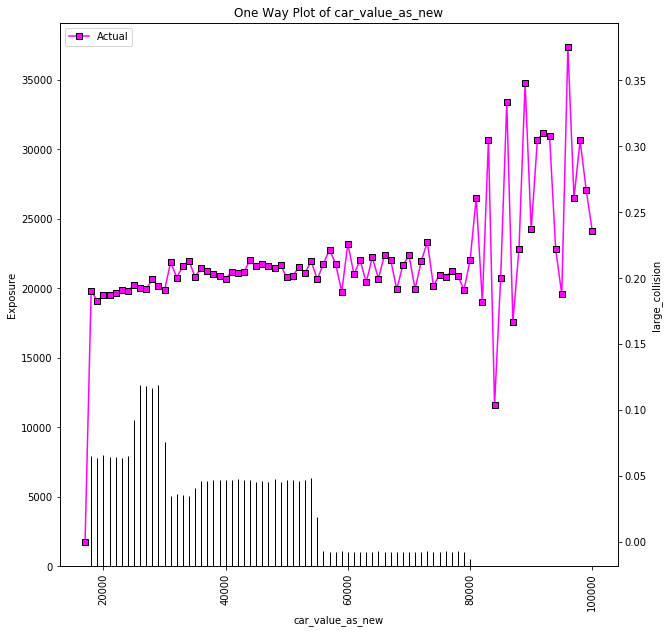

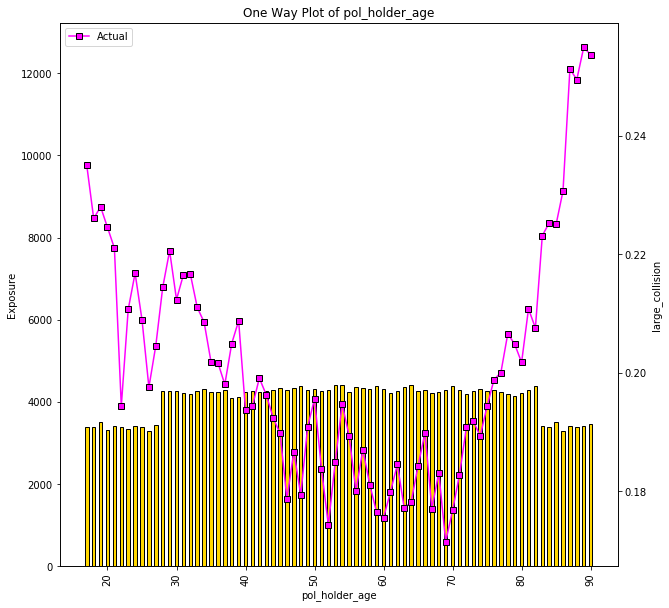

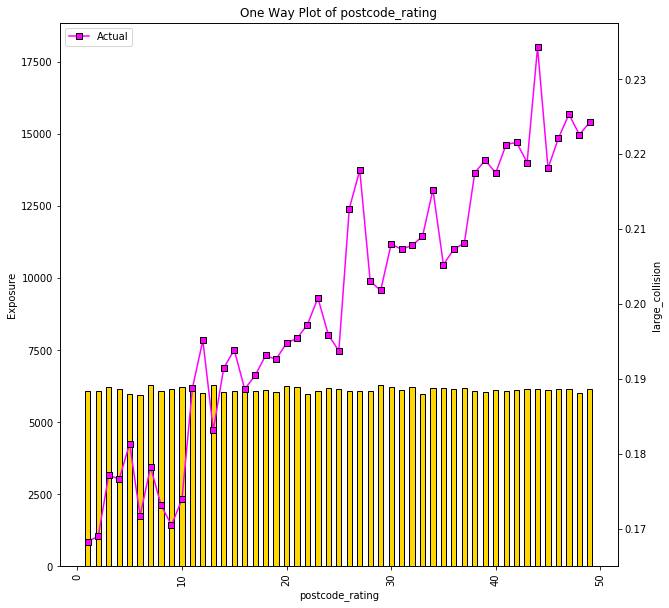

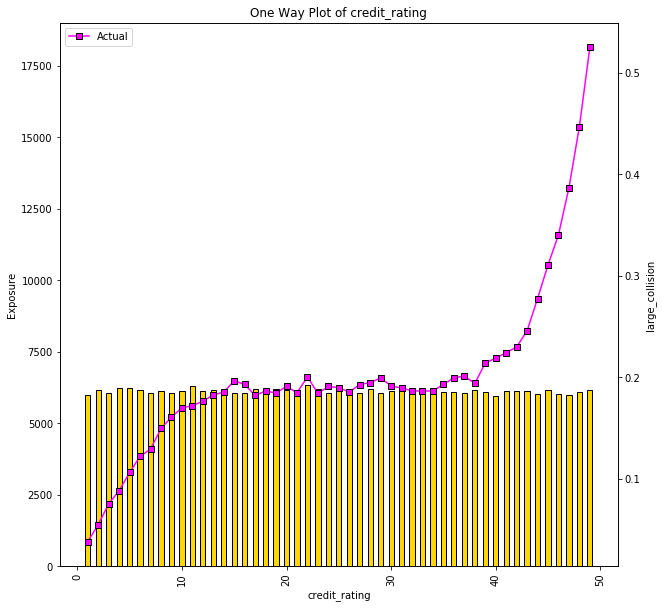

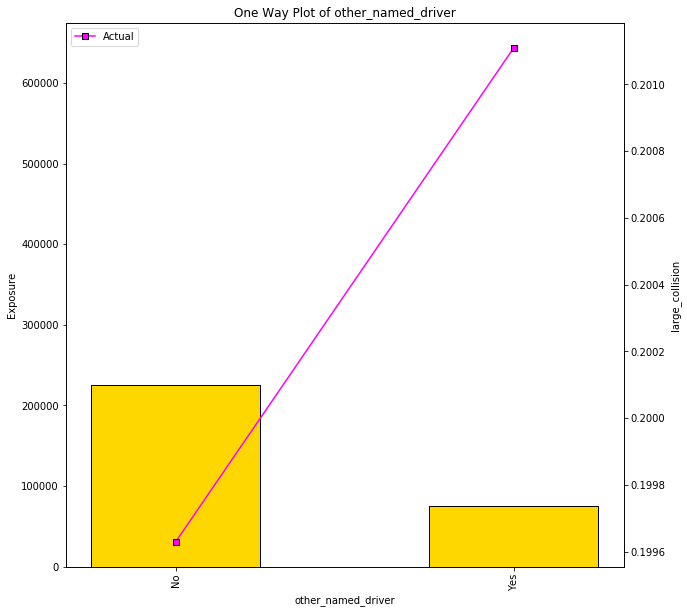

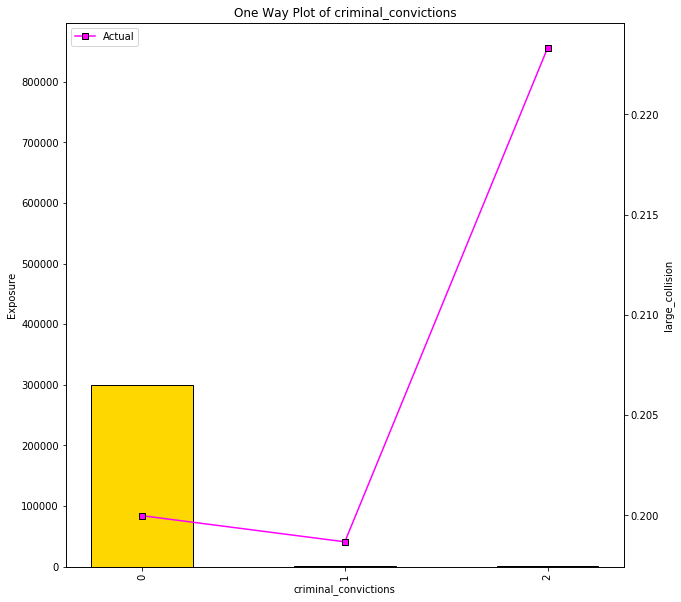

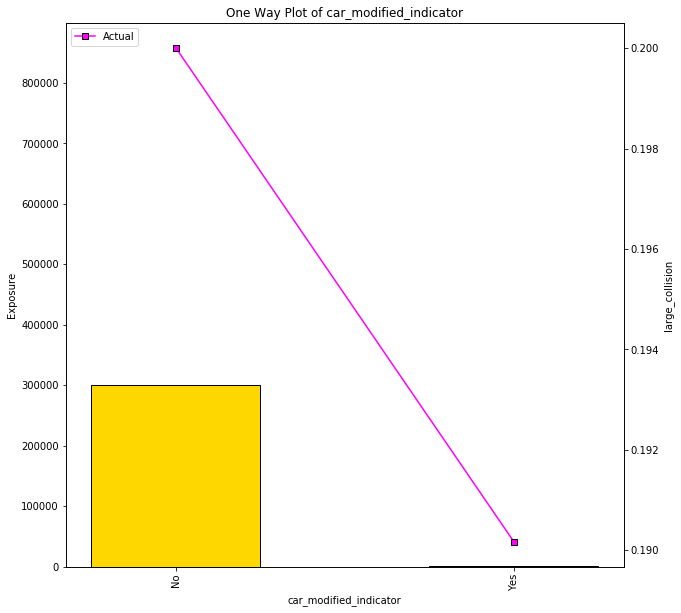

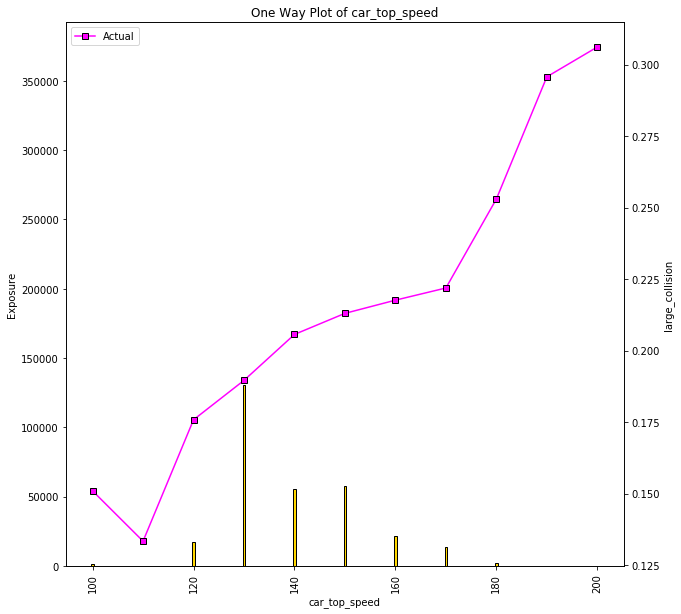

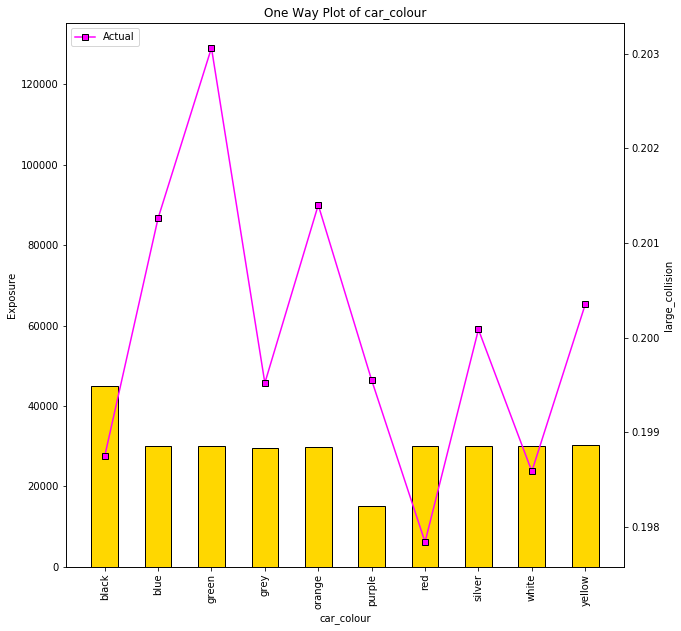

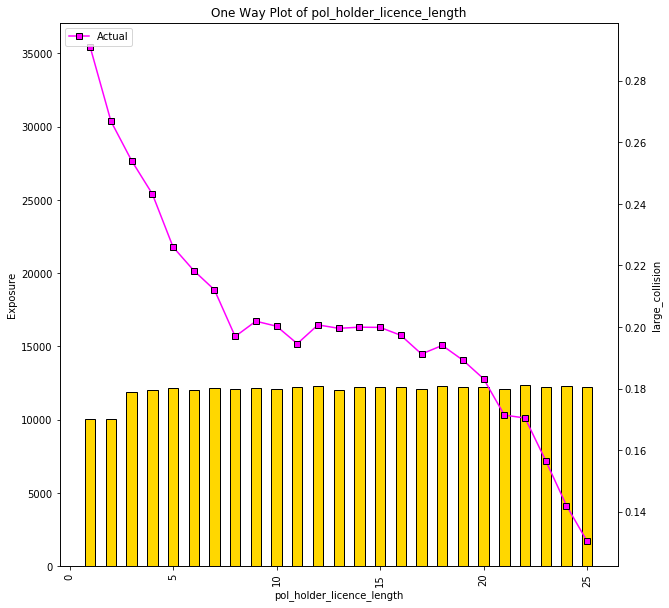

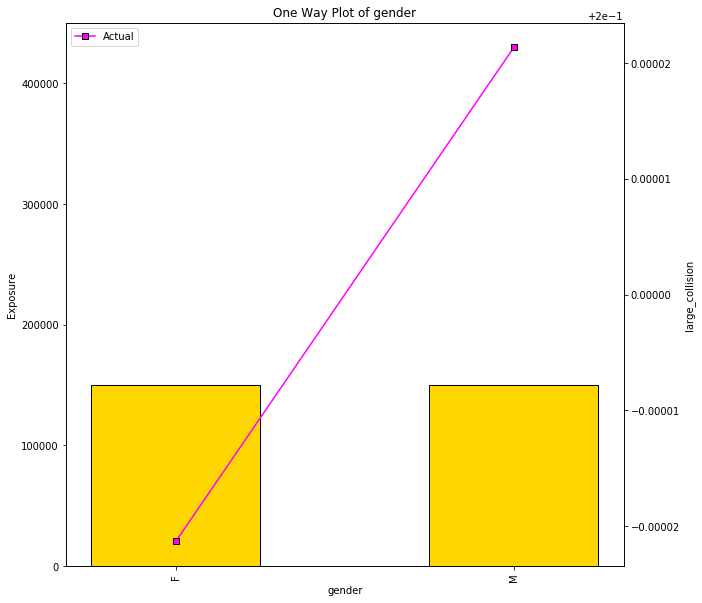

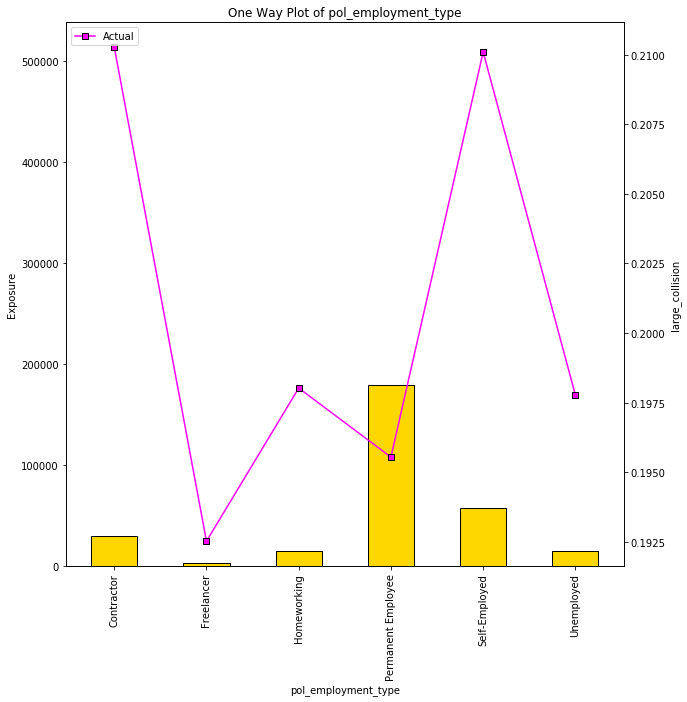

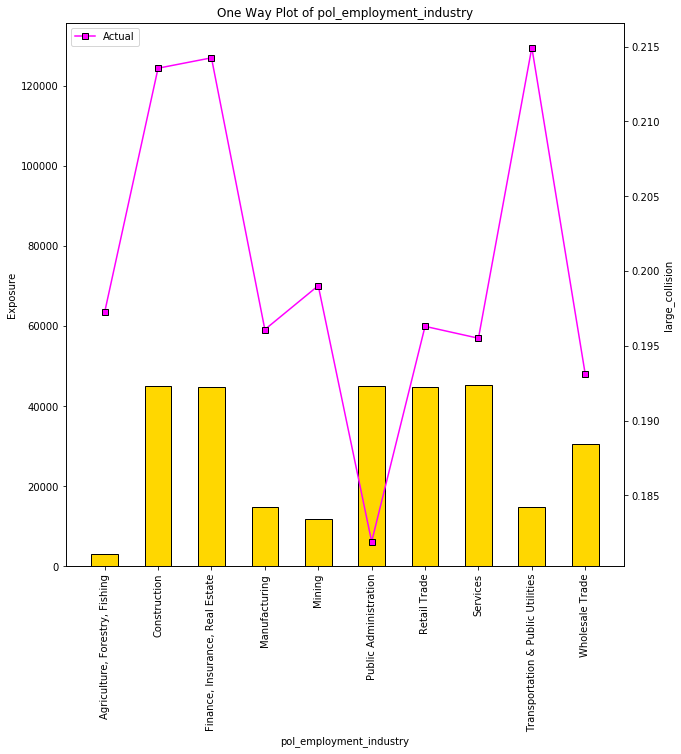

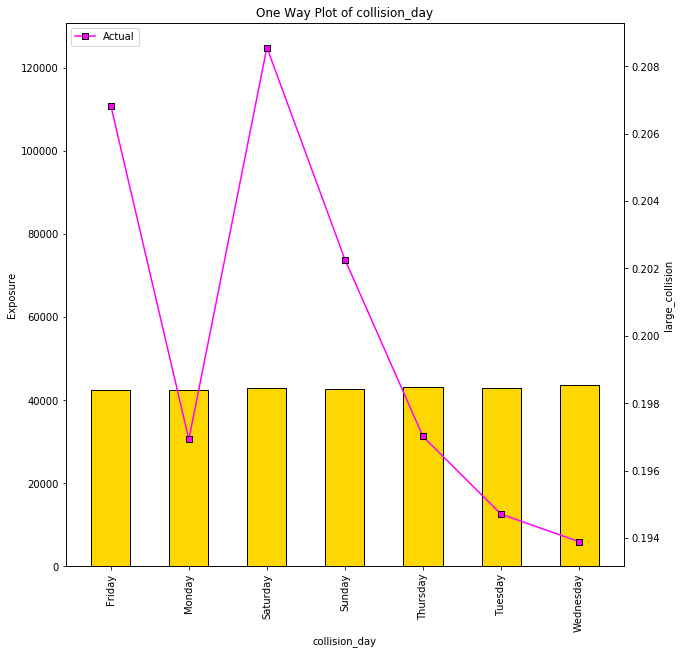

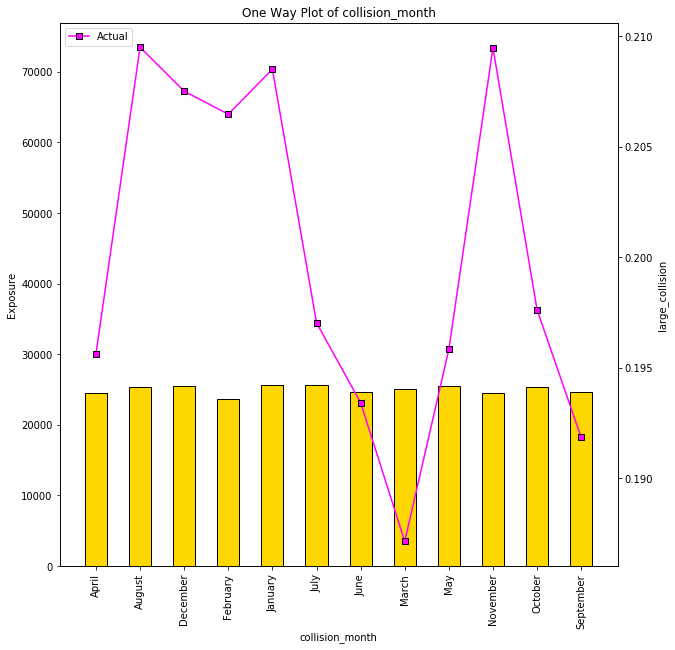

In [34]:
for i in cols:

    # values for x-graph
    exposure=df.groupby(i)['exposure'].sum()
    obs=df.groupby(i)[target_name].mean()
    diff_band=sorted(set(df[i]))

    # Bar plot
    plt.rcParams["figure.figsize"] = (10,10)
    width = 0.5
    plt.bar(diff_band, exposure, width, color='gold', label='Diff', edgecolor='k')
    plt.xticks(rotation=90)
    plt.ylim(0, max(exposure)*3)
    plt.ylabel('Exposure')
    plt.xlabel(f'{i}')
    plt.title(f'One Way Plot of {i}')

    # Line plot
    axes2 = plt.twinx()
    axes2.plot(diff_band, obs, color='fuchsia', marker="s", markeredgecolor='black', label='Actual')
    # axes2.plot(diff_band, prop, color='blue', marker="D", markeredgecolor='black', label=f'Model 2 ({model2})')
    # axes2.plot(diff_band, curr, color='g', marker="^", markeredgecolor='black', label=f'Model 1 ({model1})')
    axes2.set_ylabel(target_name)

    # legend and settings
    plt.legend(loc="upper left")

    plt.show()

# Partitioning

In [35]:
chunk=round(df.shape[0]/3,0)

# train
train=df.loc[df['id']<=chunk]

# validation
valid=df.loc[(df['id']>chunk) & (df['id']<=chunk*2)]

# test
test=df.loc[(df['id']>chunk*2)]

print(train.shape)
print(valid.shape)
print(test.shape)

(100000, 31)
(100000, 31)
(100000, 31)


In [36]:
# add a random rows with differing levels to validation dataset
lower_limit=chunk
upper_limit=chunk*2

edit_range=round(((upper_limit-lower_limit)/8),0)

criteria1=((valid['id']>lower_limit) & (valid['id']<=lower_limit+edit_range))

sports_premium_cars=['Porsche','Bentley', 'AstonMartin', 'Maserati','Rolls-Royce']
premium_cars=['AlfaRomeo','Audi', 'Infiniti', 'Lancia','Tesla','BMW', 'Jaguar', 'LandRover','Lexus','Mercedes-Benz']

criteria2=valid['car_make'].isin(sports_premium_cars)
criteria3=valid['car_make']=='Mercedes-Benz'

valid['car_make']=np.where(criteria1&criteria2, 'Lamborghini', valid['car_make'])
valid['car_make']=np.where(criteria1&criteria3, 'Tesla', valid['car_make'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [37]:
# add a random rows with differing levels to test dataset
lower_limit=chunk*2
upper_limit=chunk*3

edit_range=round(((upper_limit-lower_limit)/10),0)

criteria1=((test['id']>lower_limit) & (test['id']<=lower_limit+edit_range))

sports_premium_cars=['Porsche','Bentley', 'AstonMartin', 'Maserati','Rolls-Royce']
premium_cars=['AlfaRomeo','Audi', 'Infiniti', 'Lancia','Tesla','BMW', 'Jaguar', 'LandRover','Lexus','Mercedes-Benz']

criteria2=test['car_make'].isin(sports_premium_cars)
criteria3=test['car_make']=='Mercedes-Benz'

test['car_make']=np.where(criteria1&criteria2, 'Lamborghini', test['car_make'])
test['car_make']=np.where(criteria1&criteria3, 'Tesla', test['car_make'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


# Final Dataset

In [38]:
# subset cols
cols = [#'id',
 'pol_ref',
 'name',
 'address',
 'gender',
 'car_make',
 'car_value_as_new',
 'car_year',
 'pol_holder_age',
 'pol_employment_type',
 'pol_employment_industry',
 'pol_holder_licence_length',
 'car_top_speed',
 'postcode_rating',
 'credit_rating',
 'other_named_driver',
 'criminal_convictions',
 'car_modified_indicator',
 'car_colour',
 'collision_date',
#  'collision_day',
#  'collision_month',
#  'exposure',
#  'pol_holder_age_scl',
#  'car_value_as_new_scl',
#  'car_year_scl',
#  'postcode_rating_scl',
#  'credit_rating_scl',
#  'car_top_speed_scl',
#  'pol_holder_licence_length_scl',
 'large_collision']

In [39]:
train[cols].to_csv('data/train.csv', index=False)
test[cols].to_csv('data/test.csv', index=False)
valid[cols].to_csv('data/valid.csv', index=False)

# Notes
* Previous Owners
* Body Type